# Import des modules

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr

bc = pd.read_csv('seatle.csv')

# Selection des batiments non residentiels

In [129]:
print(f"Nombre total de batiments: {len(bc)}")
bc = bc[~bc['BuildingType'].str.contains('Multifamily', na=False)]
print(f"Nombre total de batiments non residentiels: {len(bc)}")

Nombre total de batiments: 3376
Nombre total de batiments non residentiels: 1668


# Traitement des colonnes

### <span style="color:purple"> Valeurs vides </span>
- Comments >>> Colonne vide

### <span style="color:purple"> Valeurs manquantes </span>
- Outlier >>> Valeurs manquantes
- YearsENERGYSTARCertified >>> Valeurs manquantes
- ThirdLargestPropertyUseType >>> Valeurs manquantes
- ThirdLargestPropertyUseTypeGFA >>> Valeurs manquantes
- SecondLargestPropertyUseType >>> Valeurs manquantes
- SecondLargestPropertyUseTypeGFA >>> Valeurs manquantes
- ENERGYSTARScore >>> Valeurs manquantes

### <span style="color:purple"> Valeurs constantes </span>
- DataYear, City, State >>> Valeurs constantes

### <span style="color:purple"> Valeurs non pertinentes </span>
- OSEBuildingID, PropertyName, Address, TaxParcelIdentificationNumber, LargestPropertyUseType, LargestPropertyUseTypeGFA,
DefaultData, CouncilDistrictCode, Latitude, Longitude, GHGEmissionsIntensity
- ComplianceStatus >>> Suppression de la colonne car on ne sait pas sur quelles données se baser
- BuildingType >>> Suppression car ne sera plus utilisé

### <span style="color:purple"> Conversion des valeurs </span>
- Conversion de toutes les colonnes float64 en int64 à cause des grandeurs de chiffres

In [130]:
print(f"Nombre de colonnes avant traitement: {bc.shape[1]}")

print(bc.isnull().sum().sort_values(ascending=False))

# Suppression des colonnes avec plus de 500 données manquantes
bc = bc.loc[:, bc.isnull().sum() <= 500]

# Suppression des colonnes avec des données constantes
print(f"Colonnes avec des données uniques: {bc.columns[bc.nunique() == 1].tolist()}")
bc.drop((['DataYear','City','State']), axis=1, inplace=True)

# Suppression des colonnes non pertinentes
bc.drop((['OSEBuildingID', 'PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'DefaultData', 'CouncilDistrictCode','Latitude', 'Longitude', 'GHGEmissionsIntensity','ComplianceStatus','BuildingType']), axis=1, inplace=True)

# Suppression des colonnes avec des valeurs à 0
print(f"Colonnes avec des donnees à 0: {(bc == 0).sum().sort_values(ascending=False)}")
bc.drop((['SteamUse(kBtu)']), axis=1, inplace=True)

# Sélection des colonnes float64
float_cols = bc.select_dtypes(include='float64').columns
# Arrondir et convertir en int64
for col in float_cols:
    bc[col] = bc[col].round().fillna(0).astype('int64')

print(f"Nombre de colonnes après traitement: {bc.shape[1]}")

Nombre de colonnes avant traitement: 46
Comments                           1668
Outlier                            1651
YearsENERGYSTARCertified           1570
ThirdLargestPropertyUseType        1315
ThirdLargestPropertyUseTypeGFA     1315
SecondLargestPropertyUseType        813
SecondLargestPropertyUseTypeGFA     813
ENERGYSTARScore                     574
ZipCode                              16
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SiteEUIWN(kBtu/sf)                    3
SiteEUI(kBtu/sf)                      3
SiteEnergyUseWN(kBtu)                 3
SteamUse(kBtu)                        2
SiteEnergyUse(kBtu)                   2
SourceEUIWN(kBtu/sf)                  2
SourceEUI(kBtu/sf)                    2
Electricity(kWh)                      2
Electricity(kBtu)                     2
NaturalGas(therms)                    2
NaturalGas(kBtu)                      2
TotalGHGEmissions                     2
GHGEmissionsIntensity                 2


# Traitement des valeurs erronées

### <span style="color:purple"> Colonne "Neighborhood" </span>

- Certains quartiers sont en minuscules et 1 quartier "DELRIDGE NEIGHBORHOODS" peut etre modifié en "DELRIDGE"

In [131]:
print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

# Mettre les valeurs en MAJUSCULE
bc['Neighborhood'] = bc['Neighborhood'].str.upper()

# Modifier le quartier "DELRIDGE NEIGHBORHOODS")" en "DELRIDGE"
bc.loc[bc['Neighborhood'] == "DELRIDGE NEIGHBORHOODS", 'Neighborhood'] = "DELRIDGE"

print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

Neighborhood
DOWNTOWN                  361
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                148
NORTHEAST                 128
EAST                      121
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
dtype: int64
Neighborhood
DOWNTOWN                 361
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               148
NORTHEAST                128
EAST                     121
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   56
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
dtype: int64


# Traitement des valeurs manquantes par des valeurs de remplacement
- Sur les ZIPCODE manquants, on peut récupérer le quartier et ajouter le ZIPCODE le plus probable.

In [132]:
# Étape 1 : Compter les occurrences de chaque combinaison ZipCode/Neighborhood
prob = bc.groupby(['ZipCode', 'Neighborhood']).size().reset_index(name='Count')

# Étape 2 : Pour chaque quartier, garder seulement la combinaison avec le plus d'occurrences
prob = prob.loc[prob.groupby('Neighborhood')['Count'].idxmax()]

# Étape 3 : Filtrer pour ne garder que les quartiers avec plus de 10 occurrences
prob = prob[prob['Count'] > 10]

# Étape 4 : Trier par nombre d'occurrences décroissant pour visualisation
prob = prob.sort_values('Count', ascending=False)
print(prob)

# Étape 5 : Joindre la table de correspondance Neighborhood -> ZipCode au dataset principal
bc = bc.merge(prob[['Neighborhood', 'ZipCode']], on='Neighborhood', how='left', suffixes=('', '_fill'))

# Étape 6 : Remplacer les valeurs manquantes de ZipCode par les valeurs de remplacement
bc['ZipCode'] = bc['ZipCode'].fillna(bc['ZipCode_fill'])

# Étape 7 : Supprimer la colonne temporaire de remplacement
bc = bc.drop(columns=['ZipCode_fill'])


    ZipCode           Neighborhood  Count
85    98134       GREATER DUWAMISH    178
17    98101               DOWNTOWN    133
33    98105              NORTHEAST     81
43    98109             LAKE UNION     76
63    98119  MAGNOLIA / QUEEN ANNE     63
70    98122                   EAST     58
37    98107                BALLARD     48
81    98133              NORTHWEST     48
74    98125                  NORTH     45
69    98122                CENTRAL     35
62    98118              SOUTHEAST     29
35    98106               DELRIDGE     25
57    98116              SOUTHWEST     23


# Traitement des outliers

### <span style="color:purple"> Valeurs aberrantes </span>
- NumberofBuildings : Max 111 >>> CAMPUS >>> Suppression de la donnée car aberrant
- NumberofFloors : Max 99 >>> CHURCH >>> Modification à 1 étage
- NumberofFloors : Suppression des batiments superieur à 50 étages

### <span style="color:purple"> Valeurs negatives </span>
- ElectricitykWh : Min -33826.80078 Max 80460872
- TotalGHGEmissions : Min -0,8 / Max 16870,98

### <span style="color:purple"> Valeurs à corriger </span>
- NumberofBuildings : Remplacer 0 par 1 car il y a au moins 1 batiment pour chaque ligne

🔴 Analyse IQR = Modification du coefficient à 2 au lieu de 1,5 pour ne pas supprimer trop de données

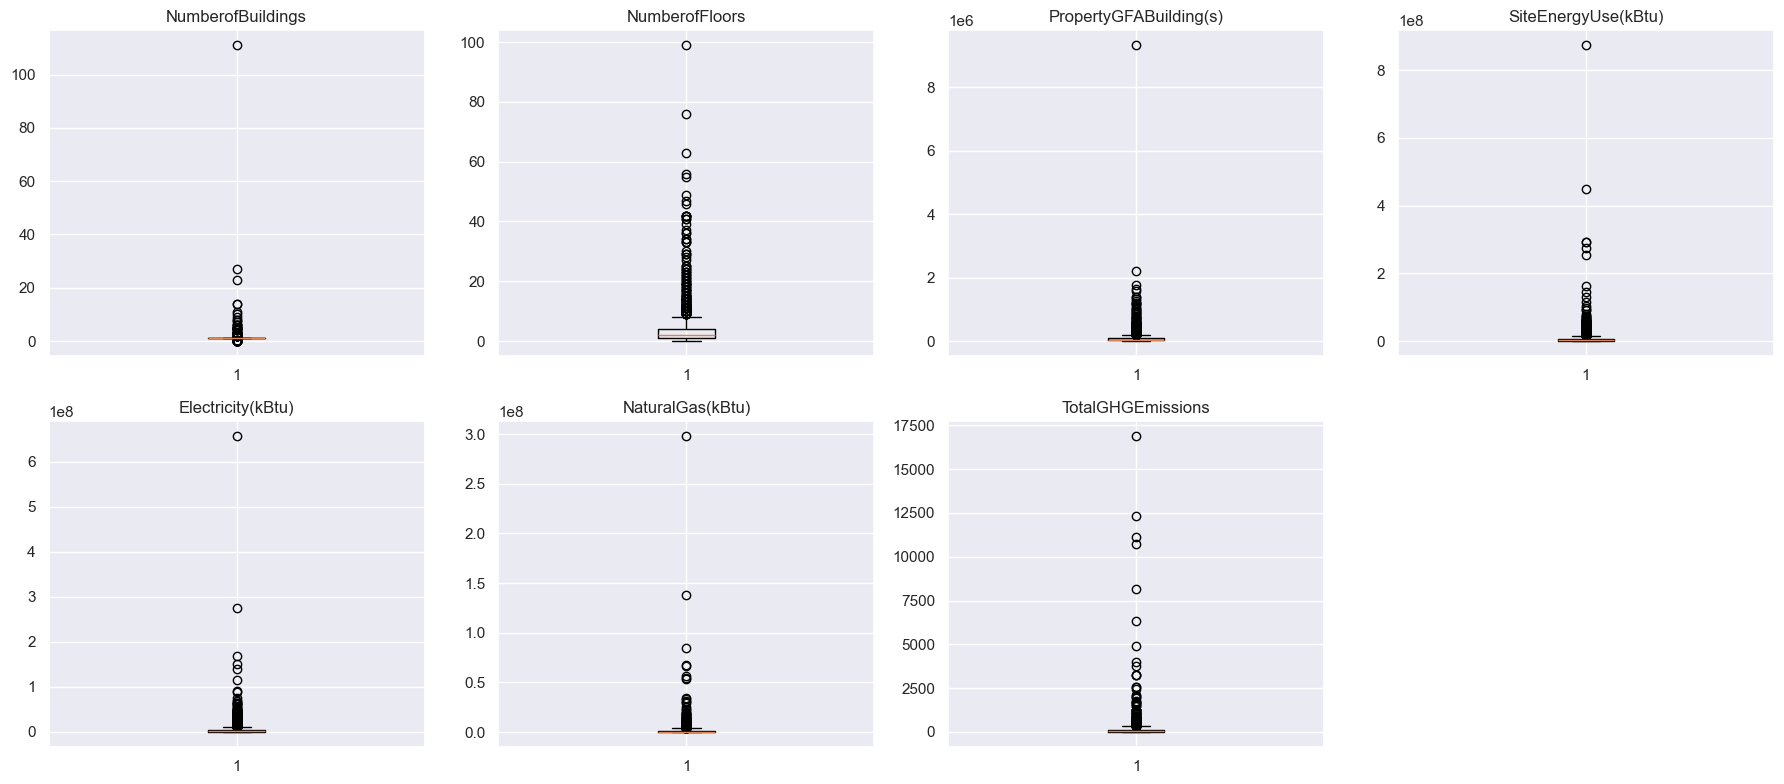

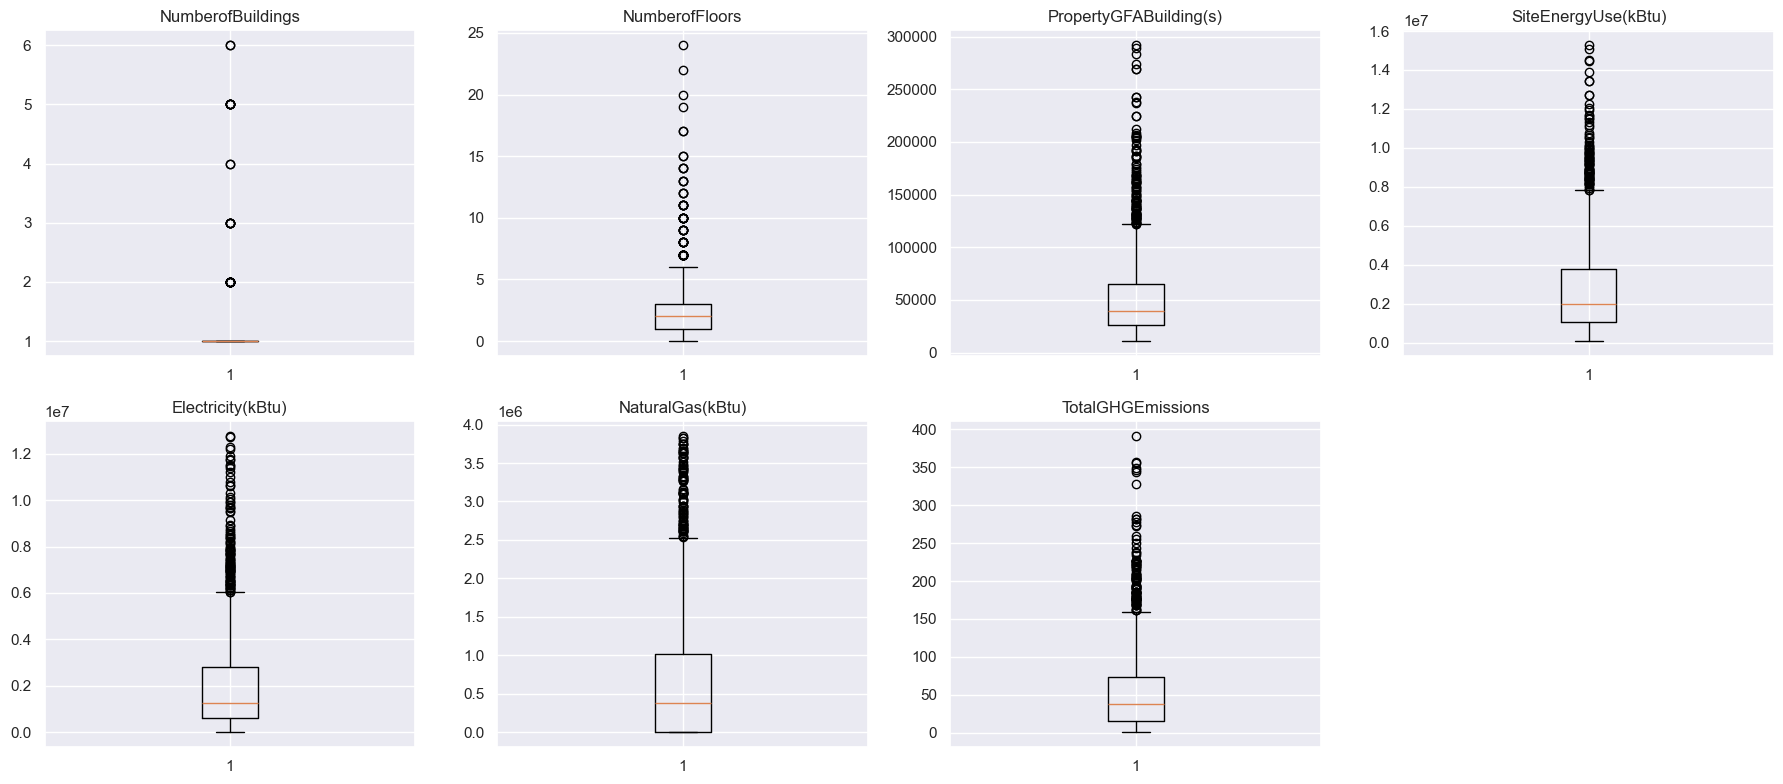

In [133]:
def analyze_iqr(data, name="Dataset"):
    #print(f"\n{name} Analysis:")
    #print("-" * 30)

    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  # Median
    q3 = np.percentile(data, 75)
    iqr = q3-q1

    #print(f"Count: {len(data)}")
    #print(f"Min: {min(data)}")
    #print(f"Q1 (25%): {q1}")
    #print(f"Q2 (50%, Median): {q2}")
    #print(f"Q3 (75%): {q3}")
    #print(f"Max: {max(data)}")
    #print(f"IQR: {iqr}")
    #print(f"IQR as % of range: {iqr / (max(data) - min(data)) * 100:.1f}%")

    # Outlier analysis
    #lower_bound = q1 - 1.5 * iqr
    lower_bound = q1 - 2 * iqr
    #upper_bound = q3 + 1.5 * iqr
    upper_bound = q3 + 2 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    #print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    #print(f"Number of outliers: {len(outliers)}")
    return outliers

#############################################

plt.figure(figsize=(18, 8))
plt.subplot(2, 4, 1)
plt.boxplot(bc['NumberofBuildings'])
plt.title('NumberofBuildings')
plt.subplot(2, 4, 2)
plt.boxplot(bc['NumberofFloors'])
plt.title('NumberofFloors')
plt.subplot(2, 4, 3)
plt.boxplot(bc['PropertyGFABuilding(s)'])
plt.title('PropertyGFABuilding(s)')
plt.subplot(2, 4, 4)
plt.boxplot(bc['SiteEnergyUse(kBtu)'])
plt.title('SiteEnergyUse(kBtu)')
plt.subplot(2, 4, 5)
plt.boxplot(bc['Electricity(kBtu)'])
plt.title('Electricity(kBtu)')
plt.subplot(2, 4, 6)
plt.boxplot(bc['NaturalGas(kBtu)'])
plt.title('NaturalGas(kBtu)')
plt.subplot(2, 4, 7)
plt.boxplot(bc['TotalGHGEmissions'])
plt.title('TotalGHGEmissions')
plt.tight_layout()
plt.show()

#############################################

# NumberofBuildings
bc = bc.drop(bc.loc[bc['NumberofBuildings'] == 111].index)
bc.loc[bc['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

# NumberofFloors
bc.loc[bc['NumberofFloors'] == 99, 'NumberofFloors'] = 1

# Electricity
ElectricitykBtu = analyze_iqr(bc['Electricity(kBtu)'], "Electricity(kBtu)") # Analyse IQR
bc.drop(bc[bc["Electricity(kBtu)"].isin(ElectricitykBtu)].index, inplace=True) # Traitement IQR
bc = bc.drop(bc.loc[bc['Electricity(kBtu)'] < 0 ].index) # Suppresion des valeurs negatives

# GAS
NaturalGaskBtu = analyze_iqr(bc['NaturalGas(kBtu)'], "NaturalGas(kBtu)") # Analyse IQR
bc.drop(bc[bc["NaturalGas(kBtu)"].isin(NaturalGaskBtu)].index, inplace=True) # Traitement IQR
bc = bc.drop(bc.loc[bc['NaturalGas(kBtu)'] < 0 ].index) # Suppresion des valeurs negatives

# CO2
#TotalGHGEmissions = analyze_iqr(bc['TotalGHGEmissions'], "TotalGHGEmissions")
#bc.drop(bc[bc["TotalGHGEmissions"].isin(TotalGHGEmissions)].index, inplace=True)
bc = bc.drop(bc.loc[bc['TotalGHGEmissions'] <= 0 ].index) # Suppresion des valeurs negatives
bc = bc.drop(bc.loc[bc['TotalGHGEmissions'] > 400 ].index) # Traitement manuel

# SiteEnergy
#SiteEnergyUsekBtu = analyze_iqr(bc['SiteEnergyUse(kBtu)'], "SiteEnergyUse(kBtu)")
#bc.drop(bc[bc["SiteEnergyUse(kBtu)"].isin(SiteEnergyUsekBtu)].index, inplace=True)
bc = bc.drop(bc.loc[bc['SiteEnergyUse(kBtu)'] <= 0 ].index) # Suppresion des valeurs negatives
bc = bc.drop(bc.loc[bc['SiteEnergyUse(kBtu)'] > 20000000 ].index) # Traitement manuel

# Surface M2
#PropertyGFABuildings = analyze_iqr(bc['PropertyGFABuilding(s)'], "PropertyGFABuilding(s)")
#bc.drop(bc[bc["PropertyGFABuilding(s)"].isin(PropertyGFABuildings)].index, inplace=True)
bc = bc.drop(bc.loc[bc['PropertyGFABuilding(s)'] > 300000 ].index) # Traitement manuel

#############################################

plt.figure(figsize=(18, 8))
plt.subplot(2, 4, 1)
plt.boxplot(bc['NumberofBuildings'])
plt.title('NumberofBuildings')
plt.subplot(2, 4, 2)
plt.boxplot(bc['NumberofFloors'])
plt.title('NumberofFloors')
plt.subplot(2, 4, 3)
plt.boxplot(bc['PropertyGFABuilding(s)'])
plt.title('PropertyGFABuilding(s)')
plt.subplot(2, 4, 4)
plt.boxplot(bc['SiteEnergyUse(kBtu)'])
plt.title('SiteEnergyUse(kBtu)')
plt.subplot(2, 4, 5)
plt.boxplot(bc['Electricity(kBtu)'])
plt.title('Electricity(kBtu)')
plt.subplot(2, 4, 6)
plt.boxplot(bc['NaturalGas(kBtu)'])
plt.title('NaturalGas(kBtu)')
plt.subplot(2, 4, 7)
plt.boxplot(bc['TotalGHGEmissions'])
plt.title('TotalGHGEmissions')
plt.tight_layout()
plt.show()


# Nettoyage des colonnes redondantes

### <span style="color:purple"> Matrice de corrélation de Pearson </span>

- SiteEUIWN(kBtu/sf) , SourceEUIWN(kBtu/sf) , SiteEnergyUseWN(kBtu), Electricity(kWh) , NaturalGas(therms) , PropertyGFATotal

* On garde KBTU comme reference

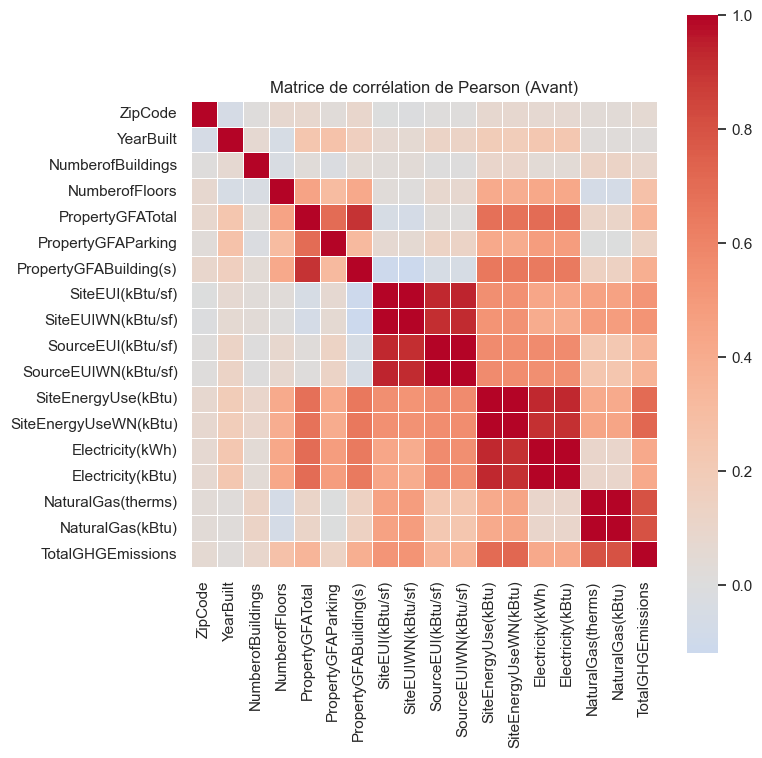

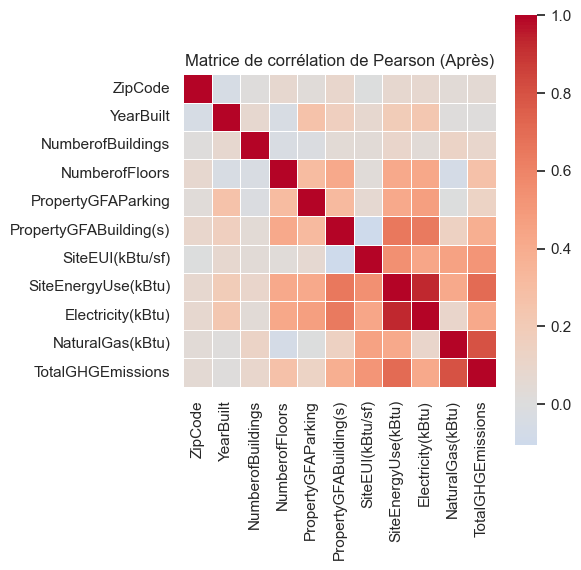

In [134]:
# Analyse de corrélation - Version initiale (avant suppression des colonnes)

# Sélectionner uniquement les colonnes numériques pour l'analyse de corrélation
numeric_cols = bc.select_dtypes(include=[np.number])
# Calculer la matrice de corrélation entre toutes les variables numériques
corrmat = numeric_cols.corr()
# Créer une figure de taille appropriée pour visualiser toutes les corrélations
f, ax = plt.subplots(figsize=(8, 8))
# Générer la heatmap de corrélation
sns.heatmap(corrmat,
           cmap='coolwarm',      # Palette de couleurs adaptée aux corrélations (bleu=négatif, rouge=positif)
           center=0,             # Centrer la palette de couleurs sur 0
           square=True,          # Cellules carrées pour un meilleur rendu visuel
           linewidths=0.5)       # Ajouter des lignes de séparation entre les cellules

plt.title('Matrice de corrélation de Pearson (Avant)')
plt.tight_layout()  # Ajuster automatiquement la mise en page
plt.show()

# Suppression des colonnes fortement corrélées ou redondantes
bc.drop((['SiteEUIWN(kBtu/sf)',
          'SourceEUI(kBtu/sf)',
          'SourceEUIWN(kBtu/sf)',
          'SiteEnergyUseWN(kBtu)',
          'Electricity(kWh)',
          'NaturalGas(therms)',
          'PropertyGFATotal']),
        axis=1, inplace=True)

# Analyse de corrélation - Version après suppression des colonnes

# Recalculer les colonnes numériques après suppression
numeric_cols = bc.select_dtypes(include=[np.number])
# Recalculer la matrice de corrélation avec les variables restantes
corrmat = numeric_cols.corr()

# Créer une nouvelle figure plus petite (moins de variables à visualiser)
f, ax = plt.subplots(figsize=(6, 6))

# Générer la nouvelle heatmap de corrélation
sns.heatmap(corrmat,
           cmap='coolwarm',      # Même palette de couleurs pour cohérence
           center=0,             # Centrer sur 0
           square=True,          # Cellules carrées
           linewidths=0.5)       # Lignes de séparation

plt.title('Matrice de corrélation de Pearson (Après)')
plt.tight_layout()
plt.show()


# Graphiques



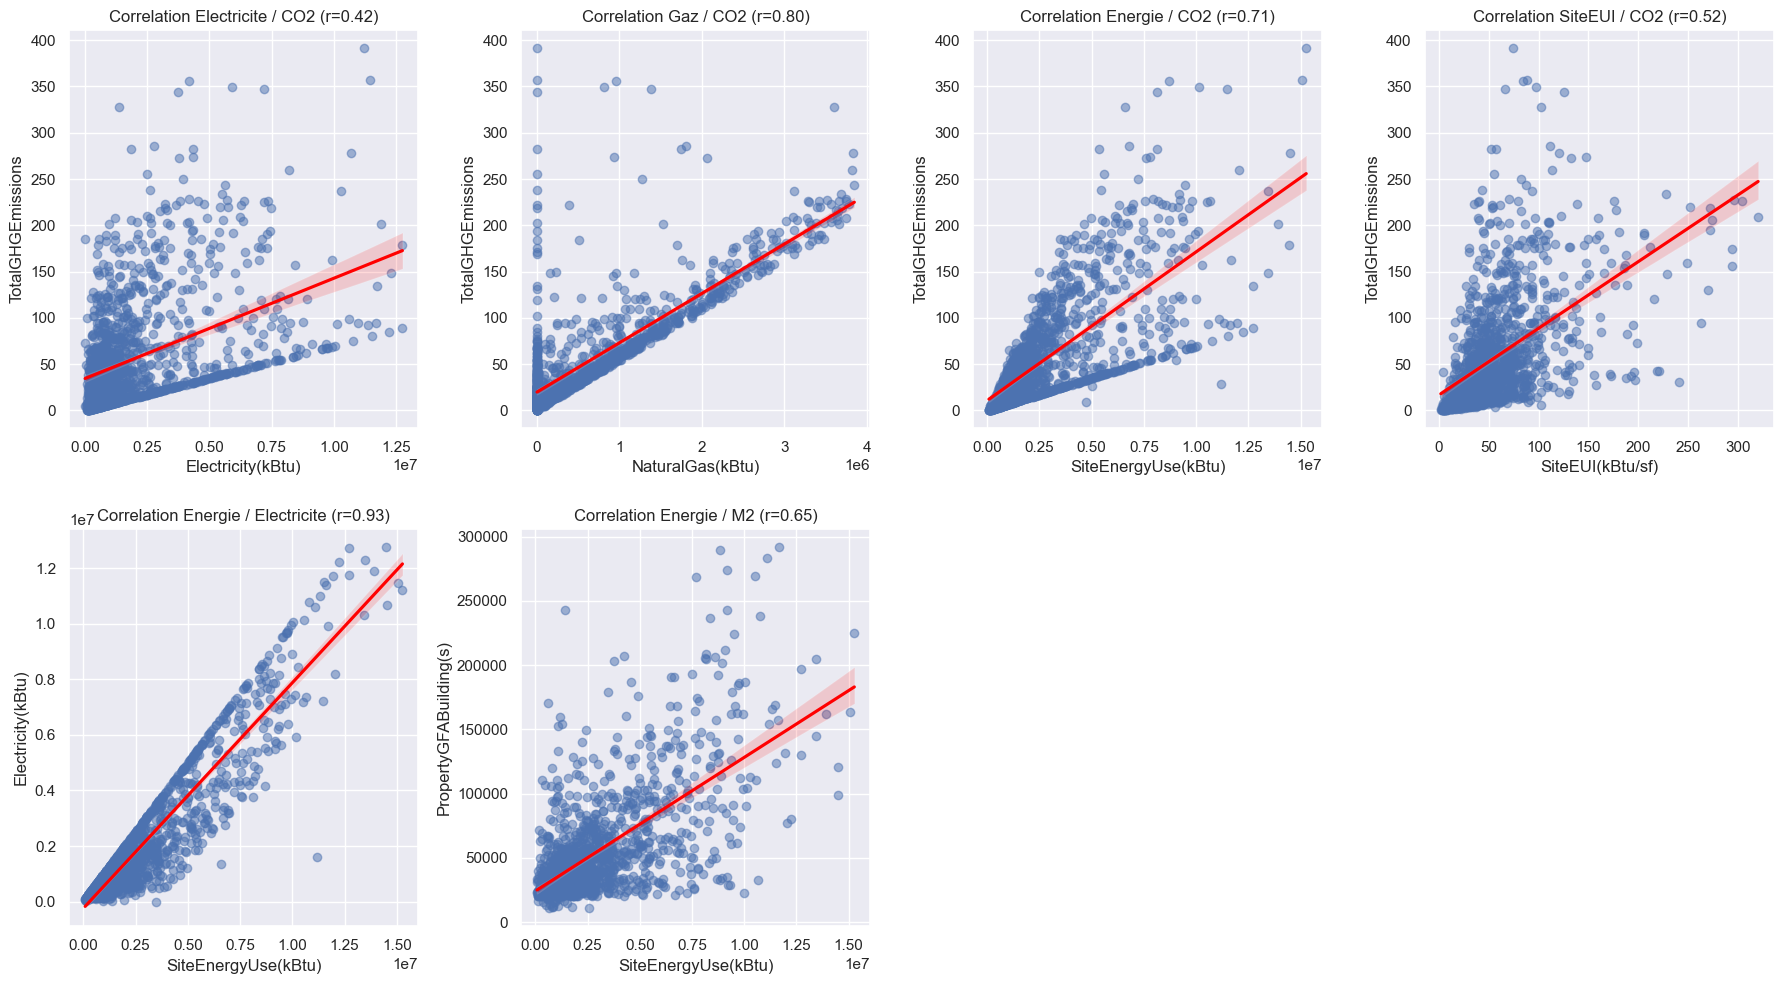

In [135]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Scatter Electricité / CO2
r, p = pearsonr(bc['Electricity(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[0, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 0].set_title(f"Correlation Electricite / CO2 (r={r:.2f})")

# Scatter Gaz / CO2
r, p = pearsonr(bc['NaturalGas(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[0, 1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 1].set_title(f"Correlation Gaz / CO2 (r={r:.2f})")

# Scatter Energie / CO2
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[0, 2], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 2].set_title(f"Correlation Energie / CO2 (r={r:.2f})")

# Scatter EUI / CO2
r, p = pearsonr(bc['SiteEUI(kBtu/sf)'], bc['TotalGHGEmissions'])
sns.regplot(x='SiteEUI(kBtu/sf)', y='TotalGHGEmissions', data=bc, ax=axes[0, 3], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 3].set_title(f"Correlation SiteEUI / CO2 (r={r:.2f})")

#############################

# Scatter M2 / Electricity
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['Electricity(kBtu)'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='Electricity(kBtu)', data=bc, ax=axes[1, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 0].set_title(f"Correlation Energie / Electricite (r={r:.2f})")

# Scatter SiteEnergy / M2
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['PropertyGFABuilding(s)'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='PropertyGFABuilding(s)', data=bc, ax=axes[1, 1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 1].set_title(f"Correlation Energie / M2 (r={r:.2f})")

axes[1, 2].axis("off")

axes[1, 3].axis("off")

plt.tight_layout()
plt.show()

# Export CSV

In [136]:
print(f"Nombre de batiments non residentiels du dataset: {len(bc)}")

# Générer la date/heure au format AAMMJJHHMMSS
timestamp = datetime.now().strftime("%y%m%d%H%M%S")
# Nom du fichier avec la date
filename_export = f"seatle_{timestamp}.csv"
filename = f"seatle_after_analyze.csv"

# Export CSV
bc.to_csv(f'exports/{filename_export}', index=False)
bc.to_csv(f'{filename}', index=False)

Nombre de batiments non residentiels du dataset: 1337
